A notebook for investigating phase error accumulated due to a tweezer of varying intensity. 

This is relevant for errors accumulated when moving our atoms, as the diffraction efficiency of the AODs varies over the move.
Because the intensity variation over a move is path dependent, there is a difference in phase accumulation between different atoms over the course of a move (e.g. when moving a grid for a transversal gate), and it seems that this is the principle issue. 

In [14]:
import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt

# units
from utils.units import *
from utils.consts import *
from utils.rbconsts import *

## intensity variation - simple
ignores:
 * moving atom tweezer -- no effects from accelerlation, e.g. atom loss
 * atom motion within the trap (which leads to motional decoherence even in a static trap from sampling the shape of the tweezer)

In [10]:
# compute the differential shift between F=1,F=2 ground states in a simple-minded way

T_tweez = 1e-3 # tweezer trap depth in mK
print(f"trap shift = {kB*T_tweez/(2*np.pi*hbar*1e6):.2f} MHz")

d1 = 2*pi*c*(1/794.978850e-9 - 1/852e-9)
d2 = 2*pi*c*(1/780.241209e-9 - 1/852e-9)
d_eff = 1/((1/d1 + 2/d2)/3) # weighted average of D lines. 
# see "Oscillator strengths of the principal series lines of Rb", table 3

omega_hfs = 2*pi*6.834682e9

eta = omega_hfs/d_eff # see "Analysis of dephasing mechanisms in a standing-wave dipole trap" by Meschede group
diff_shift = eta*T_tweez*kB/hbar
print("diff. shift/mK ~",(eta*1e-3*kB/hbar)/(2*np.pi))
print("diff. shift ~",diff_shift/(2*np.pi))

trap shift = 20.84 MHz
diff. shift/mK ~ 4814.663565388496
diff. shift ~ 4814.663565388496


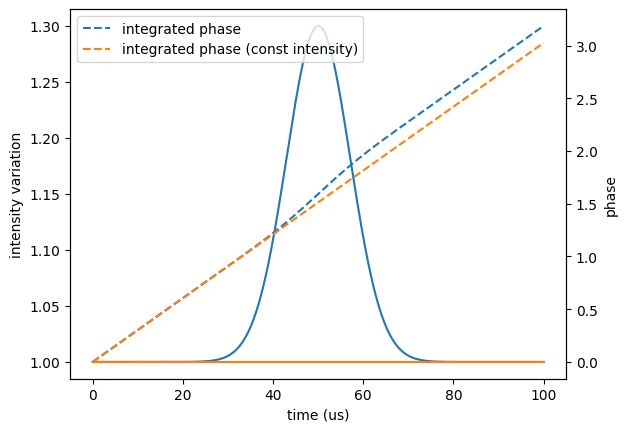

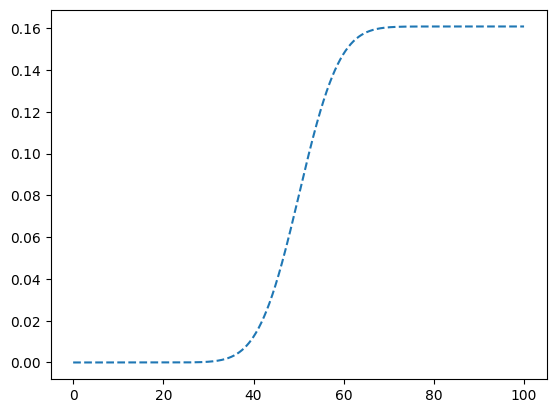

In [121]:
# kB*T = -(1/4)*alpha_0*E^2 => the trap depth is proportional to intensity

# some function that describes intensity variation. just an example
t_pts = np.linspace(0, 100*us, 2**10)
dt = t_pts[1] - t_pts[0]
f = 1/(200*us)
I_pts_const = np.ones(len(t_pts))
I_pts = 0.3*np.exp(-(20*f*(t_pts - t_pts[len(t_pts)//2]))**2) + 1


# intensity here is dimensionless; 0 would be the tweezer is off, and 1 is the nominal value when on
integrated_phase = lambda intensity: np.sum([(eta*i*T_tweez*kB/hbar)*dt for i in intensity])

fig, ax = plt.subplots()
ax.plot(t_pts/us, I_pts, label='varying intensity')
ax.plot(t_pts/us, I_pts_const, label='const intensity')

ax.set_ylabel('intensity variation')
ax2 = ax.twinx()
phase = np.array([integrated_phase(I_pts[:i]) for i in range(len(I_pts))])
ax2.plot(t_pts/us, phase, label='integrated phase',ls='--')

phase_const = np.array([integrated_phase(I_pts_const[:i]) for i in range(len(I_pts))])
ax2.plot(t_pts/us, phase_const, label='integrated phase (const intensity)', ls='--')

ax2.set_ylabel('phase')
ax.set_xlabel('time (us)')
plt.legend()

plt.show()

fig, ax = plt.subplots()
ax.plot(t_pts/us, phase - phase_const, label='integrated phase difference',ls='--')
plt.show()

In [ ]:
# todo check that I can arrive at the same phase value by using the power spectrum

## fft tests

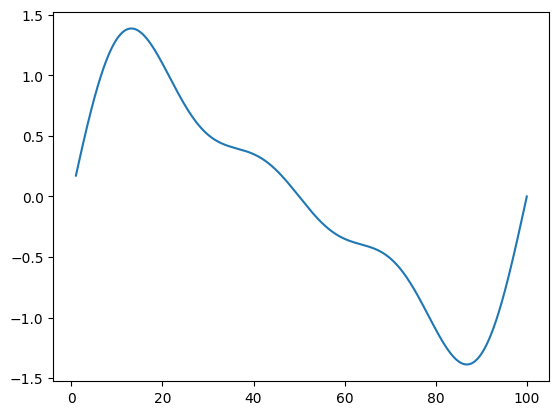

In [95]:
tmin = 1*us
tmax = 100*us
tpts = np.linspace(tmin, tmax, 2**12) # us
f1 = 1/(100*us) # = 10 kHz
f2 = 2/(100*us) # = 10 kHz
f3 = 3/(100*us) # = 10 kHz
ypts = np.sin(2*np.pi*f1*tpts) + 0.5*np.sin(2*np.pi*f2*tpts) + 0.25*np.sin(2*np.pi*f3*tpts)
plt.plot(tpts/us, ypts)

resolution = 10.1 kHz


(1.0, 100.0)

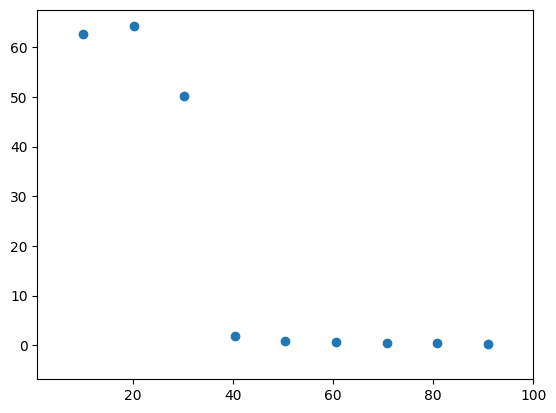

In [96]:
df = 1/(tpts[-1] - tpts[0]) # resolution limited by the total sampling time
print(f"resolution = {df/kHz:.1f} kHz")
fpts = np.array([i*df for i in range(len(tpts))])
plt.scatter(fpts/kHz, np.real(fft(ypts)))
plt.xlim((1,100))
# plt.xscale('log')